In [54]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from functools import partial
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix


In [55]:
def TPR(pred, y):
    return sum(y*pred) / sum(y)

def TNR(pred, y):
    return sum((1-y)*(1 - pred)) / sum(1 - y)

def WA(pred, y, w):
    return w * TPR(pred, y) + (1-w) * TNR(pred, y)

def f(x1, x2, a, b):
    return 1 * (x2 < a * x1 + b)

def obj_func(x1, x2, a, b, y, w):
    return WA(f(x1, x2, a, b), y, w)

In [4]:
import numpy as np

class ParticleSwarm():
    def __init__(self,  x_domain, v_max, cost_f, dimension, swarmsize, swarm=None, obj=None,   
                alpha = 0.72984, #0.72, 0.3925
                beta = 2.05, #1.5, 2.5586, 2.05
                gamma = 2.05): #1.5, 1.3358, 2.05
        self.dimension = dimension
        self.swarmsize = swarmsize
        self.cost_f = cost_f
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        if x_domain == np.inf:
            self.x_domain = 10
        else:    
            self.x_domain = x_domain
        self.v_max = v_max
        if swarm is None:
            # np.random.seed(63)
            self.swarm = np.random.uniform(-self.x_domain, self.x_domain, (self.dimension, self.swarmsize))
        else:
            self.swarm = swarm
        self.bestLocal  = self.swarm.copy() # лучшие положения частиц

        self.bestGlobal = np.zeros([self.dimension]).reshape(-1, 1) # вектор с наилучшими координатами среди всех частиц
        self.velocity = np.zeros_like(self.swarm)

    def optimum_all(self):
        list_b = []
        list_f_best = []
        for i in range(len(self.swarm[0])):
            f_best = self.cost_f(self.bestLocal[0][i], self.bestLocal[1][i])
            list_f_best.append(f_best)
            b = f_best <= self.cost_f(self.swarm[0][i], self.swarm[1][i]) 
            list_b.append(b)
        self.bestLocal[:, list_b] = self.swarm[:, list_b] #из каждой строки "bestLocal" и "swarm" формируем массив с индексами из "b"
        
        
        k = np.argmax(list_f_best)
        self.bestGlobal[0], self.bestGlobal[1] = self.bestLocal[0][k], self.bestLocal[1][k]
        
    def velocity_f(self):
        self.optimum_all()
        r1, r2 = np.random.rand(2)
        self.velocity = self.alpha * self.velocity + self.beta * r1 * (self.bestLocal - self.swarm) + self.gamma * r2 * (self.bestGlobal - self.swarm)
        self.velocity = np.minimum(self.velocity,  self.v_max)
        self.velocity = np.maximum(self.velocity, -self.v_max)


    def rate_particles(self):
        self.velocity_f()
        self.swarm = self.swarm + self.velocity #перемещение частицы
        self.swarm = np.minimum(self.swarm,  self.x_domain)
        self.swarm = np.maximum(self.swarm, -self.x_domain)
        

In [123]:
X, y = make_classification(n_samples=512, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1,random_state=90)
obj_f = partial(obj_func, X[:, 0], X[:, 1], y=y, w= 0.5)
max_iter = 500
pso_fibrin = ParticleSwarm(x_domain=50, v_max=np.inf, cost_f=obj_f, dimension=2, swarmsize=20)
for k in range(max_iter):
    pso_fibrin.rate_particles()
pso_fibrin.bestGlobal


array([[-0.80580819],
       [-0.31536018]])

In [124]:

y_pred = f(X[:, 0], X[:, 1], pso_fibrin.bestGlobal[0][0], pso_fibrin.bestGlobal[1][0])
print(precision_score(y, y_pred, average='weighted'))
print(accuracy_score(y, y_pred))
confusion_matrix(y, y_pred)


0.9397190222209374
0.935546875


array([[253,   4],
       [ 29, 226]], dtype=int64)

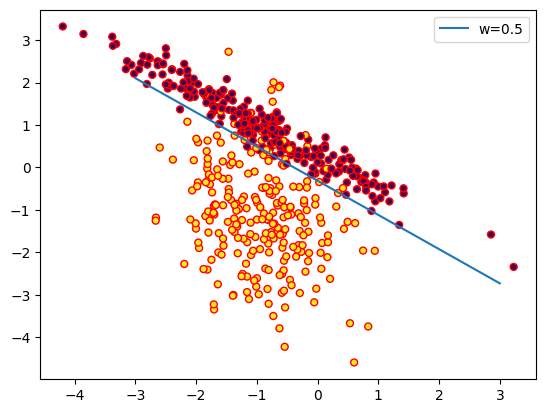

In [128]:
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="r")

x0 = np.linspace(-3, 3, 10)
y0 =  pso_fibrin.bestGlobal[0][0] * x0 + pso_fibrin.bestGlobal[1][0]
plt.plot(x0, y0, label="w=0.5", markevery=12)
# plt.plot(x0, y1, label="w=0.5", markevery=12)
plt.legend()